In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.style.use('ggplot')
import seaborn as sns

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [3]:
dataset_path = 'train.csv' 
column_names = ['Id','Province','Country/Region','Lat','Long',
                'Date', 'ConfirmedCases', 'Fatalities']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

train_dataset = raw_dataset.copy()
train_dataset.head(5);

In [4]:
import datetime

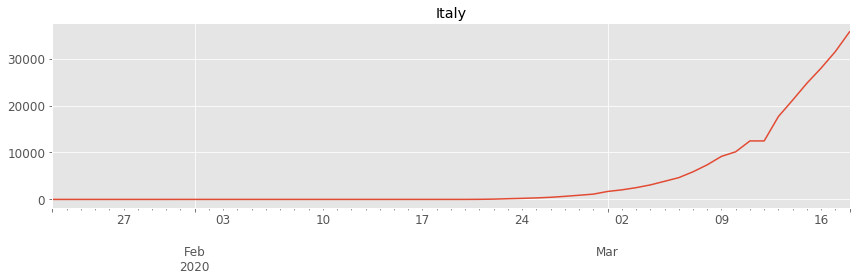

In [6]:
name = "Italy"
#mask = train_dataset["Province"] == name
mask = train_dataset["Country/Region"] == name
df_specific = train_dataset[mask]
df_specific = df_specific.reset_index()
ts = pd.Series(np.array(df_specific.ConfirmedCases), pd.date_range(df_specific.Date[0], df_specific.Date[len(df_specific) - 1])).astype('float64')

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ts.plot(ax=ax, title=name)

fig.tight_layout()
fig.savefig(name + ".pdf")

In [ ]:
country = "US"
mask = train_dataset["Country/Region"] == country
df_specific = train_dataset[mask]
df_specific = df_specific.reset_index()
provinces = set(df_specific.Province)
fig, ax = plt.subplots(len(provinces), 1, figsize=(12, 100),
                      sharex=True)
i = 0

for province in provinces:
    mask = train_dataset["Province"] == province
    df_specific = train_dataset[mask]
    df_specific = df_specific.reset_index()
    ts = pd.Series(np.array(df_specific.ConfirmedCases), pd.date_range(df_specific.Date[0], df_specific.Date[len(df_specific) - 1])).astype('float64')

    ts.plot(ax=ax[i], title=province)
    i+=1

In [ ]:
fig.tight_layout()
fig.savefig(country + ".pdf")

In [10]:
import tensorflow as tf

country = "China"
mask = train_dataset["Country/Region"] == country
df_specific = train_dataset[mask]
df_specific = df_specific.reset_index()
provinces = set(df_specific.Province)
i = 0
n = len(provinces) - 1
n_steps = 30
series = np.empty([len(provinces), n_steps + 1])

for province in provinces:
    mask = train_dataset["Province"] == province
    df_specific = train_dataset[mask]
    df_specific = df_specific.reset_index()
    series[i] = np.array(df_specific.ConfirmedCases)[:n_steps + 1]
    i+=1
    
series = series[..., np.newaxis].astype(np.float32)

In [11]:
print(series.shape)

(33, 31, 1)


In [20]:
val = 5
test = 3
X_train, y_train = series[:n - val - test, :n_steps], series[:n - val - test, -1]
X_valid, y_valid = series[n - val:n, :n_steps], series[n - val:n, -1]
X_test, y_test = series[n-test+1:, :n_steps], series[n-test+1:, -1]

In [21]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(24, 1)
(5, 1)
(3, 1)


In [15]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(24, 30, 1)
(5, 30, 1)
(1, 30, 1)


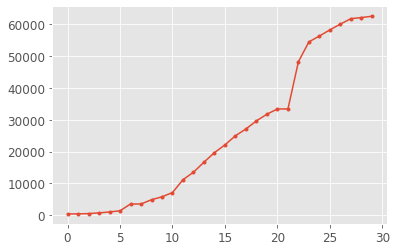

In [457]:
plt.plot(X_train[3, : , 0], ".-")

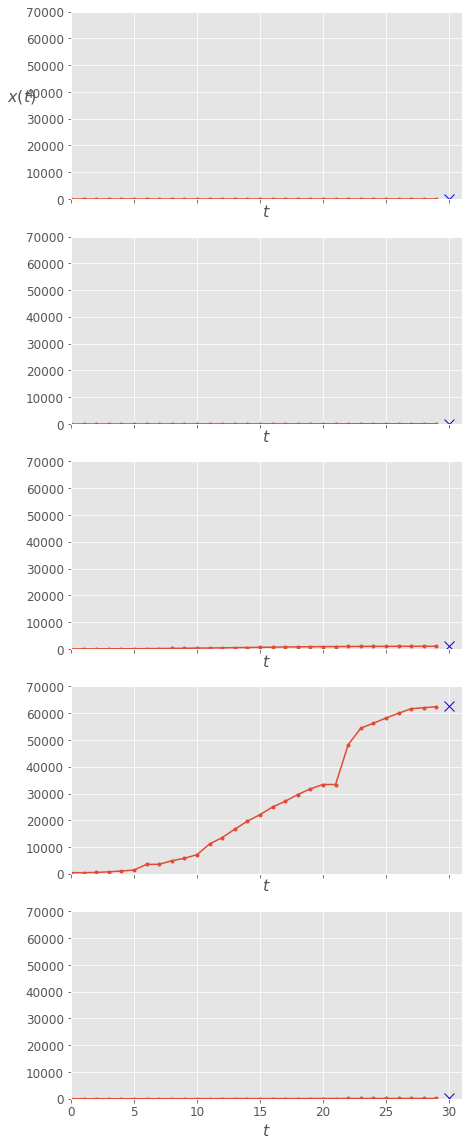

In [458]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, 0, 70000])

rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=1, sharex=True, figsize=(7, 20))
for row in range(rows):
    plt.sca(axes[row])
    plot_series(X_train[row, :, 0], y_train[row, 0],
                y_label=("$x(t)$" if row==0 else None))
#save_fig("time_series_plot")
plt.show()

In [471]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 24 samples, validate on 5 samples
Epoch 1/20
24/24 [==============================] - 3s 108ms/sample - loss: 163902400.0000 - val_loss: 226076.3438
Epoch 2/20
24/24 [==============================] - 0s 1ms/sample - loss: 163901536.0000 - val_loss: 225982.5000
Epoch 3/20
24/24 [==============================] - 0s 833us/sample - loss: 163900736.0000 - val_loss: 225892.2969
Epoch 4/20
24/24 [==============================] - 0s 1ms/sample - loss: 163899952.0000 - val_loss: 225805.7031
Epoch 5/20
24/24 [==============================] - 0s 1ms/sample - loss: 163899216.0000 - val_loss: 225722.3438
Epoch 6/20
24/24 [==============================] - 0s 1ms/sample - loss: 163898480.0000 - val_loss: 225641.7500
Epoch 7/20
24/24 [==============================] - 0s 1ms/sample - loss: 163897792.0000 - val_loss: 225563.5000
Epoch 8/20
24/24 [==============================] - 0s 1ms/sample - loss: 163897104.0000 - val_loss: 225487.1562
Epoch 9/20
24/24 [==============================]

In [486]:
model.evaluate(X_valid, y_valid)

5/1 [======================================================================================================================================================] - 0s 2ms/sample - loss: 224701.7188


224701.71875

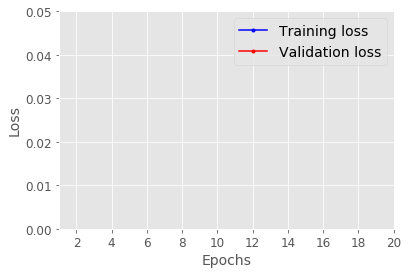

In [479]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

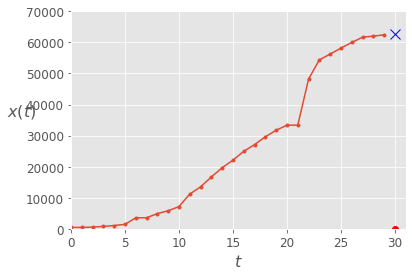

In [484]:
index = 3
y_pred = model.predict(X_train)
plot_series(X_train[index, :, 0], y_train[index, 0], y_pred[index, 0])
plt.show()